# Visualization Variant Painting Images and Cells

In [13]:
import os
import glob
import polars as pl
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from tqdm import tqdm
import re
import sys
import subprocess
from skimage.transform import resize

sys.path.append("../..")
from img_utils import *
from display_img import *
from display_cells_backup import *

## 1. Loading meta data and variant classification

In [2]:
OUT_IMG_DIR = f"../../2.snakemake_pipeline/outputs/visualize_imgs"
OUT_CELL_DIR = f"../../2.snakemake_pipeline/outputs/visualize_cells"

### 1.1 Read in the meta data

In [3]:
# allele_meta_df, img_well_qc_sum_df = pl.DataFrame(), pl.DataFrame()
# allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

# for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
#     for batch_id in bio_rep_batches:
#         allele_meta_df_batch = pl.DataFrame()
#         platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
#         for platemap in platemaps:
#             platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
#             allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
#                                         platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
#                                         how="diagonal_relaxed").sort("plate_map_name")
#             allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
#             # display(allele_meta_df.head())
#         allele_meta_df = pl.concat([
#             allele_meta_df,
#             allele_meta_df_batch
#         ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
#     allele_meta_df_dict[bio_rep] = allele_meta_df_batch

#     img_well_qc_sum = pl.read_csv(f"{IMGS_QC_METRICS_DIR}/{bio_rep}/plate-well-level_img_qc_sum.csv")
#     img_well_qc_sum = img_well_qc_sum.with_columns(
#         pl.col("channel").replace("DAPI", "DNA").alias("channel")
#     )
#     img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
#     img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
#         pl.col("is_bg").max().alias("is_bg"),
#         pl.col("s2n_ratio").mean().alias("s2n_ratio")
#     ).with_columns(pl.lit("Morph").alias("channel"))
#     img_well_qc_sum = pl.concat([
#         img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
#         img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
#     ], how="vertical_relaxed")
#     img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [4]:
allele_meta_df = pl.read_csv(IMG_METADATA_FILE, infer_schema_length=10000)
img_well_qc_sum_df = pl.read_csv(IMG_QC_SUM_DF_FILE, infer_schema_length=10000)

with open(IMG_METADATA_DICT_FILE, "rb") as f:
    allele_meta_df_dict = pickle.load(f)

with open(IMG_QC_SUM_DICT_FILE, "rb") as f:
    img_well_qc_sum_dict = pickle.load(f)

# auroc_df = pl.read_csv(f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_all.csv")
# auroc_df.unique("gene_allele")

auroc_df = pl.read_csv(f"../outputs/2.classification_results/imaging_analyses_classification_summary_all.csv", 
                       infer_schema_length=100000, separator=",")
auroc_df.unique("gene_allele")

## pillar results
# auroc_df = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_Pillar_VarChAMP/2_individual_assay_analyses/imaging/3_outputs/pillar_img_overlapped_gene_variants.csv", 
#                        infer_schema_length=100000, separator=",").with_columns(
#                            pl.lit("2025_01_Batch_13-14").alias("Metadata_Bio_Batch")
#                        )
# auroc_df.unique("gene_allele")

symbol,gene_allele,Metadata_Bio_Batch,Altered_95th_perc_both_batches_GFP_ADJ,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph,Altered_99th_perc_both_batches_GFP_ADJ,Altered_99th_perc_both_batches_GFP,Altered_99th_perc_both_batches_DNA,Altered_99th_perc_both_batches_Mito,Altered_99th_perc_both_batches_AGP,Altered_99th_perc_both_batches_Morph,AUROC_Mean_GFP_ADJ,AUROC_Mean_GFP,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,AUROC_Mean_Morph,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep1_GFP,AUROC_BioRep1_GFP_ADJ,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_BioRep2_GFP,AUROC_BioRep2_GFP_ADJ
str,str,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""CCM2""","""CCM2_Asp419Tyr""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,false,false,0.891488,0.886404,0.63019,0.683858,0.685433,0.717837,0.749523,0.654921,0.690051,0.635867,0.881036,0.8923,0.686151,0.715944,0.677665,0.624513,0.891772,0.890675
"""TTPA""","""TTPA_Ala120Thr""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,false,false,0.654089,0.67836,0.562641,0.649278,0.596095,0.625192,0.620301,0.611569,0.623257,0.59743,0.747774,0.730375,0.630084,0.580621,0.6753,0.527852,0.608946,0.577803
"""DES""","""DES_Ala135Val""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,false,false,0.663034,0.645142,0.703794,0.733954,0.712675,0.732799,0.961963,0.941927,0.960556,0.942567,0.693153,0.749856,0.503635,0.483422,0.507351,0.465021,0.597132,0.576211
"""CCM2""","""CCM2_Gly8Ser""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,false,false,0.846068,0.845708,0.754227,0.81622,0.747886,0.86712,0.844319,0.739321,0.84297,0.746558,0.848877,0.851808,0.88992,0.75645,0.789469,0.761897,0.842539,0.840328
"""BRCA1""","""BRCA1_Arg391Met""","""2025_01_Batch_13-14""",true,true,false,true,false,true,false,false,false,false,false,false,0.982943,0.981397,0.756466,0.948016,0.889698,0.930095,0.929027,0.924037,0.955958,0.751491,0.98498,0.988614,0.931163,0.85536,0.940074,0.761442,0.977814,0.977272
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""BRIP1""","""BRIP1_Val76Ile""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,false,false,0.669177,0.696371,0.698448,0.667339,0.676473,0.740594,0.805384,0.680459,0.664267,0.756858,0.679918,0.649564,0.675803,0.672488,0.67041,0.640037,0.712824,0.68879
"""DES""","""DES_Gly44Ser""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,false,false,0.76503,0.652325,0.692909,0.810611,0.78974,0.73512,0.945239,0.942767,0.953189,0.896787,0.67026,0.76503,0.525001,0.636713,0.668033,0.489031,0.634389,null
"""CCM2""","""CCM2_Leu195Pro""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,false,false,0.863164,0.872447,0.702555,0.737291,0.767821,0.812664,0.832164,0.74976,0.763844,0.663725,0.888331,0.872889,0.793163,0.785882,0.710737,0.741385,0.856562,0.853439


## 2. Plot Variant Painting Well Images

In [5]:
# def get_allele_batch(allele, score_df=auroc_df):
#     return score_df.filter(pl.col("gene_allele")==allele)["Metadata_Bio_Batch"].to_list()[0]


def save_allele_imgs(variant, feat, auroc_df=auroc_df, display=False, save_img=False):
    bio_rep = get_allele_batch(variant)
    auroc_df_batch = auroc_df.with_columns(
        pl.col(f"AUROC_Mean_{feat}").alias("AUROC_Mean"),
        pl.col(f"gene_allele").alias("allele_0")
    )
    ref_allele = variant.split("_")[0]
    ref_wells = allele_meta_df_dict[bio_rep].filter(pl.col("gene_allele")==ref_allele)["imaging_well"].to_list()
    var_wells = allele_meta_df_dict[bio_rep].filter(pl.col("gene_allele")==variant)["imaging_well"].to_list()
    target_file = [f for f in os.listdir(f"{OUT_IMG_DIR}/{bio_rep}") if f.startswith(f"{variant}_{feat}")]
    if target_file:
        print(target_file, "exists.")
        output_dir = ""
        if not display:
            return None

    if save_img:
        output_dir = f"{OUT_IMG_DIR}/{bio_rep}"
        print(f"Img output at {output_dir}")
    else:
        output_dir = ""

    if bio_rep != "2024_12_Batch_11-12":
        if len(ref_wells)==1 and len(var_wells)==1:
            plot_allele(allele_meta_df_dict[bio_rep],
                            variant=variant, sel_channel=feat, 
                            auroc_df=auroc_df_batch, 
                            plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                            site="05", max_intensity=0.99, 
                            display=display,
                            imgs_dir=TIFF_IMGS_DIR, 
                            output_dir=output_dir)
        else:
            for ref_well in ref_wells:
                for var_well in var_wells:
                    plot_allele(allele_meta_df_dict[bio_rep],
                                variant=variant, sel_channel=feat, 
                                auroc_df=auroc_df_batch, 
                                plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                                site="05", max_intensity=0.99, 
                                display=display,
                                ref_well=[ref_well], 
                                var_well=[var_well],
                                imgs_dir=TIFF_IMGS_DIR, 
                                output_dir=output_dir)
    else:
        if len(ref_wells)==4 and len(var_wells)==4:
            plot_allele_single_plate(allele_meta_df_dict[bio_rep], ##.filter(pl.col("plate_map_name").str.contains("B13")
                                     variant=variant, sel_channel=feat, 
                                     auroc_df=auroc_df_batch, 
                                     plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                                     site="05", max_intensity=0.99, 
                                     display=display,
                                     imgs_dir=TIFF_IMGS_DIR, 
                                     output_dir=output_dir)
        else:
            ref_wells_idx = len(ref_wells) // 4
            var_wells_idx = len(var_wells) // 4
            for rw_idx in range(ref_wells_idx):
                for vw_idx in range(var_wells_idx):
                    plot_allele_single_plate(allele_meta_df_dict[bio_rep], ##.filter(pl.col("plate_map_name").str.contains("B13")
                                     variant=variant, sel_channel=feat, 
                                     auroc_df=auroc_df_batch, 
                                     plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                                     site="05", max_intensity=0.99,
                                     ref_well=ref_wells[rw_idx*4:rw_idx*4+4],
                                     var_well=var_wells[vw_idx*4:vw_idx*4+4],
                                     display=display,
                                     imgs_dir=TIFF_IMGS_DIR, 
                                     output_dir=output_dir)

In [6]:
allele_list = auroc_df.filter(pl.col("symbol")=="CCM2")["gene_allele"].unique() #["FOXP3_Leu242Pro", "TPM1_Asn279His"] #auroc_df.filter(pl.col("symbol")=="MLH1")["gene_allele"].unique()
# allele_list

# for variant in tqdm(allele_list):
#     for feat in ["AGP","Mito","GFP"]:
#         # print(variant)
#         save_allele_imgs(variant, feat, display=False, save_img=True)

In [7]:
# plot_allele_separate_plot(allele_meta_df_dict["2025_01_Batch_13-14"],
#                           variant="CCM2_Ile432Thr", sel_channel="GFP", 
#                           plate_img_qc=img_well_qc_sum_dict[bio_rep], 
#                           imgs_dir=TIFF_IMGS_DIR, 
#                           site="05", max_intensity=0.99, output_dir=".")

## 3. Plot Variant Painting Cell Crop Images

### 3.1 Load and store the batch profiles for cell crop look-up

__Run only once and stored in a very large dict for easy loading__

In [8]:
# Pickle the metadata dictionary
# with open("../../2.snakemake_pipeline/outputs/visualize_cells/batch_prof_dict.pkl", "wb") as f:
#     pickle.dump(batch_profiles, f, pickle.HIGHEST_PROTOCOL)

### 3.2 Plot the cell crops

cell area and nuclei area corr with nuclei

In [9]:
# save_allele_cell_imgs("F9_Cys28Arg", feat="GFP", cell_ids=cell_ids, batch_profile_dict=batch_profiles_filtered, display=True)

In [10]:
# Cytoplasm_Intensity_MinIntensityEdge_GFP, Nuclei_Texture_InverseDifferenceMoment_GFP_20_01_256

In [11]:
# ccm2_v53i_nuc_dict = plot_var_key_feat_cell_crops("CCM2_Val53Ile", "Nuclei_Texture_InverseDifferenceMoment_GFP_5_00_256", auroc_df, sel_channel=["GFP"], compartment="Nuclei")

In [16]:
# f9_cys28arg_cell_mito = plot_var_key_feat_cell_crops("F9_Cys28Arg", "Nuclei_Correlation_K_GFP_Mito", auroc_df, sel_channel=["GFP"], compartment="Cell")
# f9_cys28arg_cell_mito = plot_var_key_feat_cell_crops("F9_Cys28Arg", "Nuclei_Correlation_K_GFP_Mito", auroc_df, sel_channel=["Mito"], compartment="Cell")

In [1]:
# f9_cys28arg_cell_agp = plot_var_key_feat_cell_crops("F9_Cys28Arg", "Cytoplasm_Texture_InfoMeas2_GFP_5_02_256", auroc_df, sel_channel=["GFP"], compartment="Cell")
# f9_cys28arg_cell_agp = plot_var_key_feat_cell_crops("F9_Ile316Thr", "Cytoplasm_Texture_InfoMeas2_GFP_5_02_256", auroc_df, sel_channel=["GFP"], compartment="Cell")

In [2]:
# f9_cys28arg_cell_mito = plot_var_key_feat_cell_crops("F9_Cys28Arg", "Nuclei_Correlation_K_GFP_Mito", auroc_df, sel_channel=["GFP", "Mito"], compartment="Cell")
# f9_ile316thr_cell_mito = plot_var_key_feat_cell_crops("F9_Ile316Thr", "Nuclei_Correlation_K_GFP_Mito", auroc_df, sel_channel=["GFP", "Mito"], compartment="Cell")

In [13]:
def viz_cell_crop_multi_ex(cell, max_intensity=0.99, ax=None, axis_off=True):
    """
    Visualize all available channels of a single cell with RGB color blending
    
    Parameters:
    -----------
    cell : dict
        Cell dictionary containing separate image crops for each channel
        Expected keys: f"img_crop_{channel}" for each channel
    max_intensity : float
        Percentile for intensity scaling (default 0.99)
    ax : matplotlib axis
        Axis to plot on (creates new if None)
    axis_off : bool
        Whether to turn off axis labels
    """
    # Find all available channels in the cell dict
    channels = []
    for key in cell.keys():
        if key.startswith("img_crop_"):
            channel = key.replace("img_crop_", "")
            channels.append(channel)
    
    if not channels:
        raise ValueError("No img_crop_{channel} keys found in cell dict list")
    
    # Get dimensions from first available channel
    first_channel = channels[0]
    first_img = cell[f"img_crop_{first_channel}"]
    height, width = first_img.shape
    
    # Initialize RGB image
    rgb_image = np.zeros((height, width, 3), dtype=np.float32)
    
    # Process each channel
    for channel in channels:
        # Get image array for this channel
        channel_key = f"img_crop_{channel}"
        img_arr = cell[channel_key]
        
        # Calculate intensity scaling for this specific channel
        channel_vmax = np.percentile(img_arr, max_intensity * 100)
        
        # Normalize image to [0, 1]
        normalized_img = np.clip(img_arr / channel_vmax, 0, 1)
        
        # Get RGB color for this channel
        rgb_color = channel_to_rgb(channel)
        
        # Add this channel's contribution to RGB image
        for i in range(3):  # R, G, B
            rgb_image[:, :, i] += normalized_img * rgb_color[i]
    
    # Clip final RGB values to [0, 1]
    rgb_image = np.clip(rgb_image, 0, 1)
    
    # Plot the combined RGB image
    if ax is None:
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_image, interpolation='bilinear')
        if axis_off:
            plt.axis('off')
        plt.show()
    else:
        ax.imshow(rgb_image, interpolation='bilinear')
        if axis_off:
            ax.axis('off')
        
        # Add label with cell information
        # key_feat_sel = list(cell.keys())[-1]
        plot_label = f"{cell['allele']}\nChannels: {', '.join(sorted(channels))}" ## \n{cell[key_feat_sel]:.2f} | 95th intensity: {cell.get('intensity_95', 'N/A'):.1f}
        ax.text(0.05, 0.95, plot_label, color='white', fontsize=9,
                verticalalignment='top', horizontalalignment='left', 
                transform=ax.transAxes,
                bbox=dict(facecolor='black', alpha=0.2, linewidth=1))
        

def viz_cell_crop_ex(cell, cell_comp, max_intensity=.99, ax=None, axis_off=True):
    img_arr = cell[f"img_crop_{cell_comp}"]
    cmap = channel_to_cmap(cell_comp)
    key_feat_sel = list(cell.keys())[-1]
    if ax is None:
        plt.imshow(img_arr, vmin=0, vmax=np.percentile(img_arr, max_intensity*100), cmap=cmap)
        if axis_off:
            plt.axis('off')  # Turn off axis labels
        plt.show()
    else:
        ax.imshow(img_arr, vmin=0, vmax=np.percentile(img_arr, max_intensity*100), cmap=cmap)
        if axis_off:
            ax.axis('off')
        # plot_label = f"s2n ratio:\n{np.percentile(img_arr, 99) / np.percentile(img_arr, 25):.3f}"
        plot_label = f"{cell['allele']}\n95th intensity:{cell[f'intensity_95_{cell_comp}']:.1f}\n{cell[key_feat_sel]:.2f}"#cell["cell_id"]
        ax.text(0.05, 0.95, plot_label, color='white', fontsize=9,
                verticalalignment='top', horizontalalignment='left', 
                transform=ax.transAxes,
                bbox=dict(facecolor='black', alpha=0.2, linewidth=1))

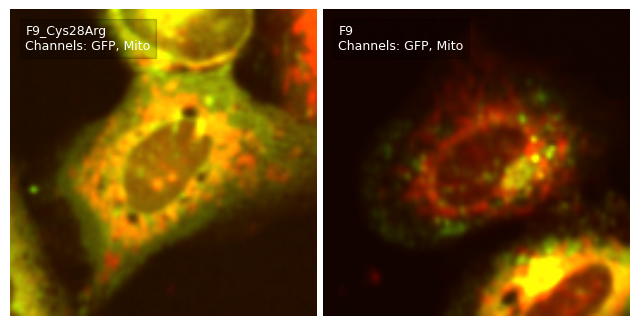

In [14]:
cells_ids = list(f9_cys28arg_cell_mito.keys())
fig, ax = plt.subplots(1, 2, figsize=(8,4))
viz_cell_crop_multi_ex(f9_cys28arg_cell_mito[cells_ids[10]], ax=ax[0])
viz_cell_crop_multi_ex(f9_cys28arg_cell_mito[cells_ids[-10]], ax=ax[1])
plt.subplots_adjust(wspace=0.02)
plt.show()

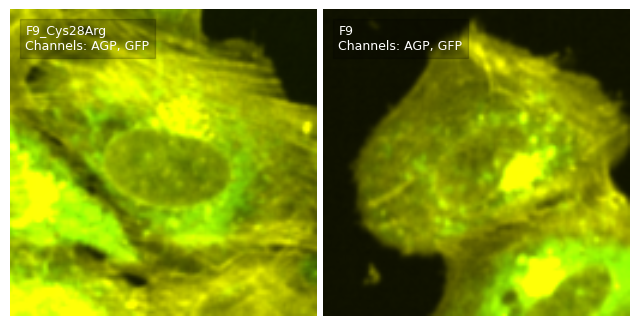

In [135]:
cells_ids = list(f9_cys28arg_cell_agp.keys())
fig, ax = plt.subplots(1, 2, figsize=(8,4))
viz_cell_crop_multi_ex(f9_cys28arg_cell_agp[cells_ids[9]], ax=ax[0])
viz_cell_crop_multi_ex(f9_cys28arg_cell_agp[cells_ids[-2]], ax=ax[1])
plt.subplots_adjust(wspace=0.02)
plt.show()

In [19]:
# cells_ids = list(f9_cys28arg_cell_dict.keys())
# fig, ax = plt.subplots(1, 2, figsize=(8,4))
# viz_cell_crop_ex(f9_cys28arg_cell_dict[cells_ids[10]], "GFP", ax=ax[0])
# viz_cell_crop_ex(f9_cys28arg_cell_dict[cells_ids[-10]], "GFP", ax=ax[1])
# plt.subplots_adjust(wspace=0.02)
# plt.show()

In [3]:
# f9_ile316thr_cell_mito = plot_var_key_feat_cell_crops("F9_Ile316Thr", "Nuclei_Correlation_K_GFP_Mito", auroc_df, sel_channel=["GFP", "Mito"], compartment="Cell")
# f9_ile316thr_cell_agp = plot_var_key_feat_cell_crops("F9_Ile316Thr", "Cells_Correlation_RWC_AGP_GFP", auroc_df, sel_channel=["AGP", "GFP"], compartment="Cell")

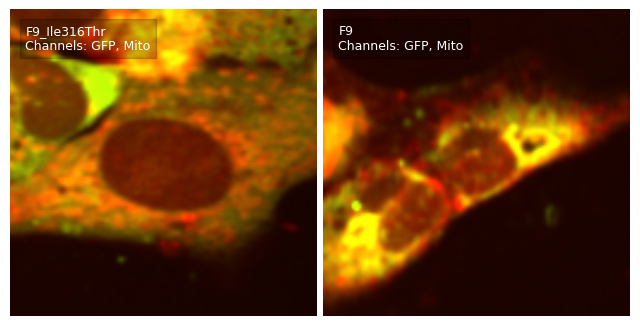

In [84]:
cells_ids = list(f9_ile316thr_cell_mito.keys())
fig, ax = plt.subplots(1, 2, figsize=(8,4))
viz_cell_crop_multi_ex(f9_ile316thr_cell_mito[cells_ids[0]], ax=ax[0])
viz_cell_crop_multi_ex(f9_ile316thr_cell_mito[cells_ids[-5]], ax=ax[1])
plt.subplots_adjust(wspace=0.02)
plt.show()

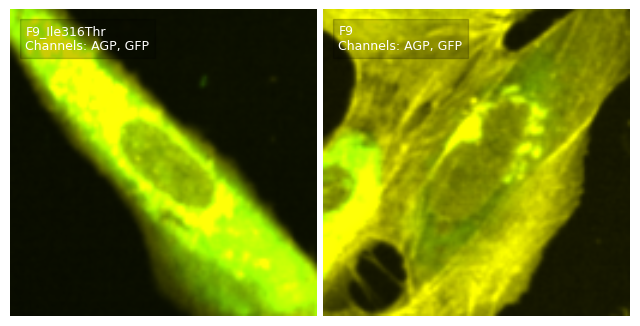

In [140]:
cells_ids = list(f9_ile316thr_cell_agp.keys())
fig, ax = plt.subplots(1, 2, figsize=(8,4))
viz_cell_crop_multi_ex(f9_ile316thr_cell_agp[cells_ids[2]], ax=ax[0])
viz_cell_crop_multi_ex(f9_ile316thr_cell_agp[cells_ids[-14]], ax=ax[1])
plt.subplots_adjust(wspace=0.02)
plt.show()

In [ ]:
# plot_var_key_feat_cell_crops("F9_Cys28Arg", "Nuclei_Correlation_K_GFP_Mito")
# plot_var_key_feat_cell_crops("F9_Cys28Arg", "Nuclei_Correlation_K_GFP_Mito", ["Mito"])
# plot_var_key_feat_cell_crops("F9_Cys28Arg", "Cytoplasm_Correlation_RWC_DNA_GFP")

In [17]:
# f9_ile316thr_cell_dict = plot_var_key_feat_cell_crops("F9_Ile316Thr", "Cytoplasm_Correlation_RWC_DNA_GFP", auroc_df, sel_channel=["DAPI", "GFP"], compartment="Cells", resize_fig=True)
# plot_var_key_feat_cell_crops("F9_Cys28Arg", "Cytoplasm_Correlation_RWC_DNA_GFP", "DAPI")
# plot_var_key_feat_cell_crops("F9_Ile316Thr", "Nuclei_Correlation_K_GFP_Mito")
# plot_var_key_feat_cell_crops("F9_Ile316Thr", "Cytoplasm_Correlation_RWC_DNA_GFP", "DAPI")

In [91]:
[c for c in pl.scan_parquet(prof_path).collect_schema() if "Correlation" in c and "GFP" in c and "AGP" in c]

['Cells_Correlation_RWC_GFP_AGP',
 'Nuclei_Correlation_RWC_GFP_AGP',
 'Cells_Correlation_Overlap_AGP_GFP',
 'Nuclei_Correlation_K_GFP_AGP',
 'Cytoplasm_Correlation_RWC_AGP_GFP',
 'Nuclei_Correlation_Correlation_AGP_GFP',
 'Cytoplasm_Correlation_Overlap_AGP_GFP',
 'Cytoplasm_Correlation_Correlation_AGP_GFP',
 'Nuclei_Correlation_RWC_AGP_GFP',
 'Nuclei_Correlation_Overlap_AGP_GFP',
 'Cells_Correlation_Correlation_AGP_GFP',
 'Cells_Correlation_K_GFP_AGP']

In [ ]:
pl.scan_parquet(BATCH_PROFILES_GFP_FILTERED.format(batch_id))

In [102]:
batch_profiles_filtered = {}
key_feat_sel = "Nuclei_Correlation_K_GFP_Mito"
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    if bio_rep != "2025_01_Batch_13-14":
        continue
    # print(bio_rep)
    for batch_id in BIO_REP_BATCHES_DICT[bio_rep]:
        # print(bio_rep, batch_id)
        imagecsv_dir = IMG_ANALYSIS_DIR.format(batch_id) #f"../../../8.1_upstream_analysis_runxi/2.raw_img_qc/inputs/images/{batch_id}/analysis"
        prof_path = BATCH_PROFILES_GFP_FILTERED.format(batch_id)
        # print(prof_path)
        # Get metadata
        profiles_filt = pl.scan_parquet(prof_path).select(
            ["Metadata_well_position", "Metadata_ImageNumber", "Metadata_ObjectNumber", "Metadata_Plate", "Metadata_refvar_gfp_adj_classify", key_feat_sel, "Cells_Correlation_RWC_AGP_GFP", GFP_INTENSITY_COLUMN
            # "Nuclei_AreaShape_Area", "Cells_AreaShape_Area", "Nuclei_AreaShape_Center_X", "Nuclei_AreaShape_Center_Y",
            # "Cells_AreaShape_BoundingBoxMaximum_X", "Cells_AreaShape_BoundingBoxMaximum_Y", "Cells_AreaShape_BoundingBoxMinimum_X",
            # "Cells_AreaShape_BoundingBoxMinimum_Y",	"Cells_AreaShape_Center_X",	"Cells_AreaShape_Center_Y",
            # "Cells_Intensity_MeanIntensity_GFP", "Cells_Intensity_MedianIntensity_GFP", "Cells_Intensity_IntegratedIntensity_GFP"
            ],
        ).collect()
    
        # Sort by allele, then image number
        profiles_filt = profiles_filt.with_columns(
            # pl.concat_str(["Metadata_Plate", "Metadata_well_position", "Metadata_Site"], separator="_").alias("Metadata_SiteID"),
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_well_position",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID"),
        ).select(["Metadata_CellID", "Metadata_refvar_gfp_adj_classify", key_feat_sel, "Cells_Correlation_RWC_AGP_GFP", GFP_INTENSITY_COLUMN]).join(
            batch_profiles[batch_id], on="Metadata_CellID", how="inner"
        )
        # profiles = profiles.sort(["Protein_label", "Metadata_SiteID"])
        # alleles = profiles.select("Protein_label").to_series().unique().to_list()
        batch_profiles_filtered[batch_id] = profiles_filt

select_cell_ids_df = pl.DataFrame()
variants_list = ['F9_Asn166Tyr', 'F9_Cys335Tyr', 'F9_Cys335Trp', 'F9_Arg294Gln',
       'F9_Ile316Thr', 'F9_Trp453Arg', 'F9_Cys28Arg', 'F9_Pro333Leu']
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    if bio_rep != "2025_01_Batch_13-14":
        continue
    for batch_id in BIO_REP_BATCHES_DICT[bio_rep]:
        select_cell_ids_df = pl.concat([
            select_cell_ids_df,
            batch_profiles_filtered[batch_id].filter(
                pl.col("Metadata_refvar_gfp_adj_classify").str.extract_all(r'|'.join(variants_list)).list.len() > 0
                # (pl.col("Cells_AreaShape_Area") < 7000) & (pl.col("Cells_AreaShape_Area") > 5000),
            ).sort("Metadata_gene_allele")
        ])

In [103]:
# from scipy.stats import spearmanr
# ax = sns.regplot(
#     data=select_cell_ids_df.to_pandas(),
#     x=key_feat_sel,
#     y=GFP_INTENSITY_COLUMN,
#     ci=False,
#     fit_reg=False
# )
# # ax.set_xlim(None, 0.5)

# rho, p_val = spearmanr(
#     select_cell_ids_df.to_pandas()[key_feat_sel], 
#     select_cell_ids_df.to_pandas()[GFP_INTENSITY_COLUMN]
# )
# print(rho, p_val)
# plt.show()

['F9', 'F9_Cys28Arg', 'F9_Asn166Tyr', 'F9_Arg294Gln', 'F9_Ile316Thr', 'F9_Pro333Leu', 'F9_Cys335Trp', 'F9_Cys335Tyr', 'F9_Trp453Arg']


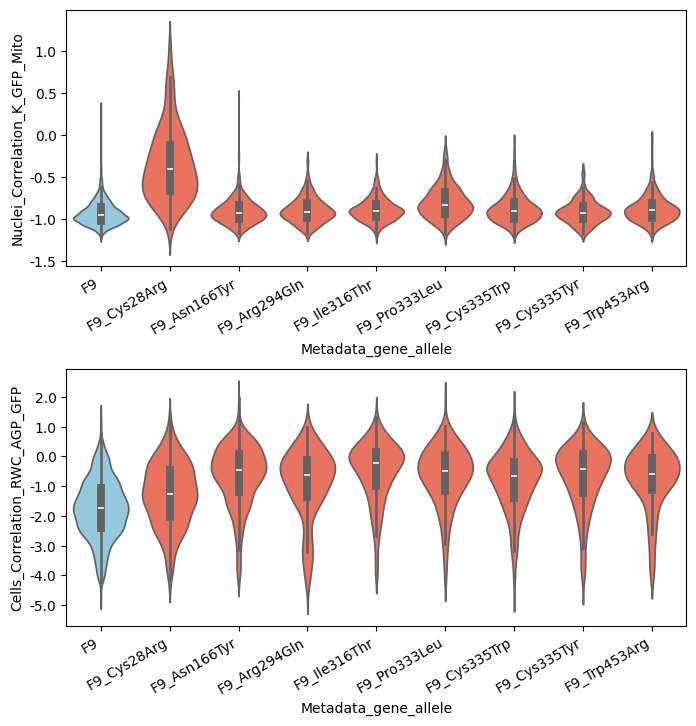

In [184]:
fig, axes = plt.subplots(2,1,figsize=(8,8))

# Get unique alleles and ensure proper type
unique_alleles = select_cell_ids_df["Metadata_gene_allele"].unique().to_list()
unique_alleles = [str(x) for x in unique_alleles]  # Ensure strings

if "F9" not in unique_alleles:
    unique_alleles.append("F9")

def extract_position(allele):
    if allele == 'F9':
        return -1
    import re
    # Skip the F9_ prefix and find the number
    match = re.search(r'[A-Za-z]+(\d+)[A-Za-z]+', allele)
    return int(match.group(1)) if match else float('inf')

# Create new list and sort
alleles = sorted(list(unique_alleles), key=extract_position)
print(alleles)

color_palette = {
    key: ("tomato" if key != "F9" else "skyblue")
    for key in alleles
}

for ax in axes:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
    
sns.violinplot(
    data=select_cell_ids_df.to_pandas(),
    x="Metadata_gene_allele",
    y=key_feat_sel,
    hue="Metadata_gene_allele",
    palette=color_palette,
    order=alleles,
    ax=axes[0],
)
for tick in axes[0].get_xticklabels():
    tick.set_rotation(30)
    tick.set_horizontalalignment('right')
sns.violinplot(
    data=select_cell_ids_df.to_pandas(),
    x="Metadata_gene_allele",
    y="Cells_Correlation_RWC_AGP_GFP",
    ax=axes[1],
    hue="Metadata_gene_allele",
    palette=color_palette,
    order=alleles
)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(30)
    tick.set_horizontalalignment('right')
plt.subplots_adjust(hspace=0.4)
plt.show()

In [27]:
# save_allele_cell_imgs("FOXP3_Leu242Pro", feat="GFP", batch_profile_dict=batch_profiles, display=True)
# save_allele_cell_imgs("TPM1_Asn279His", feat="GFP", batch_profile_dict=batch_profiles, display=True)
# save_allele_cell_imgs("RAD51D_Glu233Gly", feat="GFP", batch_profile_dict=batch_profiles, display=True)
# save_allele_cell_imgs("RAD51D_Val28Leu", feat="GFP", batch_profile_dict=batch_profiles, display=True)

# for variant in tqdm(allele_list): ## ["F9_Ile316Thr"]
#     for feat in ["AGP","Mito","GFP"]:
#         save_allele_cell_imgs(variant, feat=feat, batch_profile_dict=batch_profiles, display=False, save_img=True)

# plot_allele_cell_multi(allele_meta_df_dict["2025_01_Batch_13-14"], variant, 
#                  sel_channel=["AGP","Mito","GFP"], 
#                  plate_img_qc=img_well_qc_sum_dict["2025_01_Batch_13-14"],
#                  auroc_df=None, batch_profile_dict=batch_profiles, display=True, 
#                  # output_dir=f"{OUT_CELL_DIR}/2025_01_Batch_13-14"
# )

In [2]:
# save_allele_cell_imgs("RAD51D_Val28Leu", feat="GFP", batch_profile_dict=batch_profiles, display=True)

## 3. Multi-channel overlay

In [58]:
# save_allele_cell_imgs("MVK_Ser329Asn", feat="GFP", batch_profile_dict=batch_profiles, display=True)

In [57]:
# save_allele_cell_imgs("MLH1_Ile36Asn", feat="GFP", batch_profile_dict=batch_profiles, display=True)

In [ ]:
# rsync -avz username@server_ip:/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/visualize_imgs/2025_01_Batch_13-14/F9*.png /local/destination/path/